# Bayesian tuner for best model architecture selection 

# 1. Set up

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1201277105675525230
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 5934706174917248832
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!pip install tensorflow-addons --quiet
!pip install keras-tuner --quiet

     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 98 kB 3.1 MB/s 


In [ ]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import models
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.vgg19 import preprocess_input
import os
import tempfile

import keras_tuner
from keras_tuner import HyperModel

from keras.utils.vis_utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define paths:
pathtoCSV = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/CSV_Files/'
pathtoImages = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/'

#2. Input Pipeline

In [ ]:
def read_labels( pathtoCSV ):
  labels_csv = pd.read_csv(pathtoCSV + 'Train_Val_Reshuffle_SINGLE.csv',dtype=str)
  labels_csv['Class'] = labels_csv['Class'].astype(int)
  classes_zero = labels_csv[labels_csv['Class'] == 0]
  classes_one = labels_csv[labels_csv['Class'] == 1]
  bal = abs(int(len(classes_one) - len(classes_zero)))
  labels_csv.drop((labels_csv.query('Class== 0').sample(n=bal).index),inplace = True)
  return labels_csv

labels_csv = read_labels(pathtoCSV)

In [ ]:
def image_generator(pathtoImages ):
  train_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  val_datagen = ImageDataGenerator(
      preprocessing_function = preprocess_input,
  )
  labels_csv['Class'] = labels_csv['Class'].astype(str)
  labels_csv['File_name'] = labels_csv['File_Name'].astype(str)


  train_generator = train_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Train',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )

  val_generator = val_datagen.flow_from_dataframe(
      labels_csv,
      directory = pathtoImages + 'Validation',
      x_col = 'File_Name',
      y_col = 'Class',
      target_size = (224,224),
      color_mode='rgb',
      shuffle=True,
      seed= 1,
      class_mode = 'binary',
      batch_size = 16
  )
  return train_generator, val_generator

train_generator, val_generator = image_generator(pathtoImages)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 465 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1669 validated image filenames belonging to 2 classes.
Found 465 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1669 invalid image filename(s) in x_col="File_Name". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


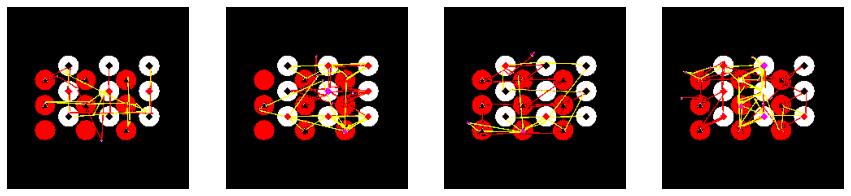

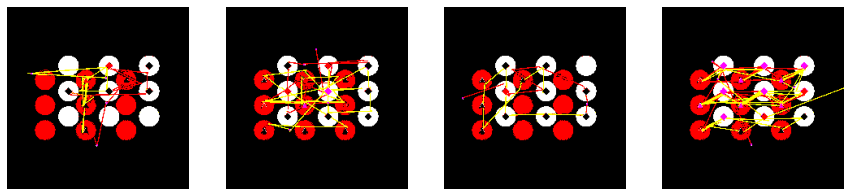

In [ ]:
# plotting train images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):
  # convert to unsigned integers for plotting
  image = next(train_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

# plotting val images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  image = next(val_generator)[0][i].astype('float')
  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].axis('off')

#3. Bayesian tuner 

In [ ]:
# Define early-stopping:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=4, 
    mode='auto',
    restore_best_weights=True)

In [ ]:
# Define Metrics:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5),
]


In [ ]:
# Original code source for regularizer: https://sthalles.github.io/keras-regularizer/


class HyperModel1(HyperModel): 
  def build(self, hp):
    base_model = VGG19(weights='imagenet', include_top=False)
    for layers in base_model.layers:
      layers.trainable=False
    x= base_model.output
    x= GlobalAveragePooling2D()(x)
    x = Dense(units=hp.Int('units', 64, 1024, 64), activation='relu')(x) 
    x = Dropout(hp.Float('dropout', min_value = 0.2, max_value = 0.7, step = 0.1))(x) 
    output=Dense(1,activation='sigmoid')(x)
    model = Model(inputs=base_model.inputs, outputs=output) 
    
    regularizer=tf.keras.regularizers.L1L2(1e-5)
    
    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)

    # load the model from the config
    model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    model.load_weights(tmp_weights_path, by_name=True)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    1e-5,
    decay_steps=100000,
    decay_rate=0.75,
    staircase=True)
    opt = SGD(learning_rate = lr_schedule, momentum=0.99) 
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=METRICS)

    return model

hypermodel = HyperModel1()

In [ ]:
# Bayesian optimization:
Bayesiantuner = keras_tuner.BayesianOptimization(
    hypermodel,
    objective='val_accuracy',
    max_trials=25,
    seed = 1
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
Bayesiantuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 1024, 'step': 64, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.7, 'step': 0.1, 'sampling': None}


In [ ]:
Bayesiantuner.search(train_generator,
epochs=30,
callbacks=[early_stopping],
validation_data=val_generator)

Trial 25 Complete [00h 21m 55s]
val_accuracy: 0.7053763270378113

Best val_accuracy So Far: 0.7311828136444092
Total elapsed time: 09h 00m 57s
INFO:tensorflow:Oracle triggered exit


In [ ]:
Bayesiantuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 1024
dropout: 0.5000000000000001
Score: 0.7311828136444092
Trial summary
Hyperparameters:
units: 1024
dropout: 0.5000000000000001
Score: 0.7290322780609131
Trial summary
Hyperparameters:
units: 1024
dropout: 0.5000000000000001
Score: 0.7290322780609131
Trial summary
Hyperparameters:
units: 1024
dropout: 0.6000000000000001
Score: 0.7204301357269287
Trial summary
Hyperparameters:
units: 1024
dropout: 0.7000000000000002
Score: 0.7182795405387878
Trial summary
Hyperparameters:
units: 1024
dropout: 0.7000000000000002
Score: 0.7182795405387878
Trial summary
Hyperparameters:
units: 1024
dropout: 0.5000000000000001
Score: 0.7182795405387878
Trial summary
Hyperparameters:
units: 1024
dropout: 0.7000000000000002
Score: 0.7161290049552917
Trial summary
Hyperparameters:
units: 1024
dropout: 0.5000000000000001
Score: 0.7161290049552917
Trial summ

In [ ]:
best_hp = Bayesiantuner.get_best_hyperparameters()[0]
model1 = Bayesiantuner.hypermodel.build(best_hp)
model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
!mkdir -p saved_models_and_weights
model1.save(filepath = pathtoSave + 'VGG_19_EQ_bayesian_tuner')

INFO:tensorflow:Assets written to: /content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/VGG19/VGG_19_EQ_bayesian_tuner/assets
